In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
import cProfile
from timeit import default_timer as timer
from scipy.integrate import odeint
from scipy.optimize import fsolve
from scipy.stats import norm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
colors = sns.color_palette(n_colors=10)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Constantes del Sistema

Se definen las dimensiones de una bomba tríplex CAT 1015 (https://www.catpumps.com/products/pumps/15-frame-plunger-pump-1051)

In [3]:
# Constantes y dimensiones del eje cigueñal:
Crank_rho = 7750
Crankpin_rad = 0.046
Crankpin_len = 0.030
Crankpin_offset = 0.015
Crankpin_mass = Crank_rho * np.pi * Crankpin_rad**2 * Crankpin_len
Crankpin_inertia = (Crankpin_mass * Crankpin_rad**2) / 2 + Crankpin_mass * Crankpin_offset**2

Web_rad = 0.050
Web_len = 0.015
Web_mass = Crank_rho * np.pi * Web_rad**2 * Web_len
Web_inertia = (Web_mass * Web_rad**2) / 2

Motor_shaft_rad = 0.015
Motor_shaft_len = 0.070
Motor_shaft_mass = Crank_rho * np.pi * Motor_shaft_rad**2 * Motor_shaft_len
Motor_shaft_inertia = (Motor_shaft_mass * Motor_shaft_rad**2) / 2

Crankshaft_inertia = 2 * Motor_shaft_inertia + 4 * Web_inertia + 3 * Crankpin_inertia

Se definen las constantes del sistema en base al modelo de Steve Miller diseñado en MATLAB (Steve Miller (2024). Predictive Maintenance in a Hydraulic Pump (https://github.com/mathworks/Simscape-Triplex-Pump/releases/tag/24.1.2.7), GitHub. )

In [4]:
# Constantes del sistema:
omega_ref = 958                                                 # Velocidad angular de referencia en RPM
Kp = 0.04                                                       # Factor de ganancia proporcional del controlador P-I
Ki = 0.002                                                      # Factor de ganancia integral del controlador P-I
B_b = 0.0001 / (2 * np.pi / 360)                                # Factor de amortiguamiento o fricción en los rodamientos del cigueñal en N*m/(rad/s)
J_b = Crankshaft_inertia                                        # Inercia del cigueñal de la bomba en kg*m^2
eta = 100                                                       # Eficiencia general del motor y del controlador
omega_eta = 958                                                 # Velocidad a la que se mide la eficiencia, convertida a rad/s
tau_eta = 1                                                     # Torque a la que se mide la eficiencia
k = (omega_eta * (1 - eta / 100)) / (tau_eta * eta / 100)       # Constante de proporcionalidad para las pérdidas resistivas
V = 24                                                          # Voltaje de entrada
fc = 200                                                        # Frecuencia de corte del filtro pasa bajos
Tc = 0.02                                                       # Constante de tiempo del controlador del torque
max_torque = 5                                                  # Torque máximo del motor en N*m

nu = 97.6333e-6                                                 # Viscosidad cinemática del fluido en m^2/s (asumimos ISOTHERMAL)
beta = 1.46696e9                                                # Isothermal bulk modulus [Pa]
rho_liquid = 851.6                                              # Densidad del líquido puro en kg/m^3 (asumimos ISOTHERMAL)

rho_air = 1.225                                                 # Densidad del aire en kg/m^3 (asumimos ISOTHERMAL)
n = 1                                                           # Air polytropic index
alpha = 0.005                                                   # Volumetric fraction of entrained air in fluid mixture
P_atm = 101325                                                  # Presión de referencia en Pa
Delta_P = 700000                                                # Diferencial de presión o carga entre entrada y salida de la bomba

epsilon = 15e-6                                                 # Rugosidad absoluta en metros
D = 0.03                                                        # Diámetro interior de la sección transversal de la tubería circular
L = 5                                                           # Longitud de la tubería en metros
L_aggregate = 1                                                 # longitud equivalente agregada debido a resistencias locales en metros
L_e = L + L_aggregate                                           # Longitud equivalente

cyl_gap = 0.0005
cyl_outer_rad = 0.0225
cyl_len = 0.105
cyl_stroke = 0.03

plunger_rad = 0.012                                             # Radio de la base del émbolo en metros 
plunger_len = 0.075

max_cyl_leak = np.pi * ((plunger_rad + cyl_gap)**2 - plunger_rad **2)

stroke = 0.03                                                   # Carrera del cilindro en metros
S = (np.pi * plunger_rad**2)                                    # Área sección transversal del émbolo
V_dead = 8e-6                                                   # Volúmen muerto correspondiente al volúmen no desplazado del cilindro
F_brk = 0.25                                                    # Fuerza de fricción de arranque en N
F_C = 0.2                                                       # Fuerza de fricción de Coulomb en N
V_brk = 0.1                                                     # Velocidad de fricción de arranque en m/s
V_St = V_brk * np.sqrt(2)                                       # Umbral de velocidad de Stribeck en m/s
V_Coul =  V_brk / 10                                            # Umbral de velocidad de Coulomb en m/s
f_fric = 0.1                                                    # Coeficiente de fricción viscosa en N/(m/s)

A_leak = 1e-12                                                  # Área mínima del orificio de la válvula check en metros
A_max = 1e-4                                                    # Área máxima del orificio de la válvula check en metros
P_crack = 30000                                                 # Presión mínima de apertura de la válvula check en Pa
P_max = 120000                                                  # Presión máxima de apertura de la válvula check en Pa
Re_cr = 150                                                     # Número de Reynolds crítico
Cd = 0.7                                                        # Coeficiente de descarga de la válvula
A_orifice = 1e-9                                                # Área nominal de fuga en m2

Se definen las condiciones iniciales del sistema para el ejercicio de simulación en la operación de la bomba tríplex. Además se definen los umbrales máximos de degradación para ``B_b``, ``A_max``, y ``A_orifice``.

In [5]:
# Condiciones iniciales
P_in0 = P_atm
P_out0 = P_atm + Delta_P
rho_in0 = (rho_liquid + (alpha / (1 - alpha)) * rho_air) / (np.exp(-(P_in0 - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_in0) ** (1 / n))
rho_out0 = (rho_liquid + (alpha / (1 - alpha)) * rho_air) / (np.exp(-(P_out0 - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_out0) ** (1 / n))
Tr0 = Kp * omega_ref
tau_ref0 = 0
omega_b0 = 0
theta_b0 = 0
omega_f0 = 0
integral_error0 = 0
P_cyl_10 = P_atm
P_cyl_20 = P_atm
P_cyl_30 = P_atm

B_b_crank = B_b
A_max_in_1 = A_max
A_max_in_2 = A_max
A_max_in_3 = A_max
A_orifice_cyl_1 = A_orifice
A_orifice_cyl_2 = A_orifice
A_orifice_cyl_3 = A_orifice

#thresholds
th_B_b = B_b * 11.83 
th_A_max = A_leak
th_A_orifice = A_max

Se definen las funciones del sistema para simular la operación de la bomba tríplex, 

In [6]:
# Funciones del sistema:
def sistema(y, t):
    
    global B_b_normal
    global A_max_in_1_normal
    global A_max_in_2_normal
    global A_max_in_3_normal
    global A_orifice_1_normal
    global A_orifice_2_normal
    global A_orifice_3_normal
    
    # Desempaquetado de las variables de estado diferenciables "y"
    P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3 = y
    
    ########################################## Émbolo N°1 ##########################################
    
    # Densidad y Módulo de Volúmen de la mezcla al interior del cilindro
    rho_cyl_1 = (rho_liquid + (alpha / (1 - alpha)) * rho_air) / (np.exp(-(P_cyl_1 - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_cyl_1) ** (1 / n))   
    beta_cyl_1 =  (beta * np.exp(-(P_cyl_1 - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_cyl_1) ** (1 / n)) / (np.exp(-(P_cyl_1 - P_atm) / beta) + beta * (1 / n) * (alpha / (1 - alpha)) * (P_atm ** (1 / n) / P_cyl_1 ** ((1 / n) + 1)))

    # Ecuaciones de la válvula de entrada
    P_diff_in_cyl_1 = P_in - P_cyl_1
    A_valve_in_cyl_1 = max(min(((P_diff_in_cyl_1 - P_crack) / (P_max - P_crack)) * (A_max_in_1 - A_leak) + A_leak, A_max), A_leak)
    rho_in_cyl_1 = (rho_in + rho_cyl_1) / 2    # densidad promedio que atraviesa la válvula
    P_cr_in_cyl_1 = ((np.pi * rho_in_cyl_1) / (8 * A_valve_in_cyl_1)) * (nu * Re_cr / Cd)**2
    m_dot_in_cyl_1 = (Cd * A_valve_in_cyl_1 * np.sqrt(2 * rho_in_cyl_1) * P_diff_in_cyl_1) / ((P_diff_in_cyl_1**2 + P_cr_in_cyl_1**2)**(1/4))

    # Ecuaciones del orificio de fuga
    P_cr_orifice_cyl_1 = ((np.pi * rho_cyl_1) / (8 * A_orifice_cyl_1)) * (nu * Re_cr / Cd)**2
    m_dot_orifice_cyl_1 = np.max((Cd * A_orifice_cyl_1 * np.sqrt(2 * rho_cyl_1) * (P_cyl_1 - P_atm)) / (((P_cyl_1 - P_atm)**2 + P_cr_orifice_cyl_1**2)**(1/4)), 0)

    # Ecuaciones de la válvula de salida
    P_diff_out_cyl_1 = P_cyl_1 - P_out
    A_valve_out_cyl_1 = max(min(((P_diff_out_cyl_1 - P_crack) / (P_max - P_crack)) * (A_max - A_leak) + A_leak, A_max), A_leak)
    rho_out_cyl_1 = (rho_out + rho_cyl_1) / 2
    P_cr_out_cyl_1 = ((np.pi * rho_out_cyl_1) / (8 * A_valve_out_cyl_1)) * (nu * Re_cr / Cd)**2
    m_dot_out_cyl_1 = (Cd * A_valve_out_cyl_1 * np.sqrt(2 * rho_out_cyl_1) * P_diff_out_cyl_1) / ((P_diff_out_cyl_1**2 + P_cr_out_cyl_1**2)**(1/4))

    # Caudales de entrada y salida
    Q_dot_in_cyl_1 = np.max(m_dot_in_cyl_1, 0) / rho_in_cyl_1
    Q_dot_out_cyl_1 = np.max((m_dot_out_cyl_1 - m_dot_orifice_cyl_1), 0) / rho_out_cyl_1

    Vol_cyl_1 = V_dead + S * (stroke/2 - stroke/2 * np.cos(theta_b))
    Vel_cyl_1 = stroke/2 * omega_b * np.sin(theta_b)

    F_cyl_1 = (P_atm - P_cyl_1) * S
    F_fric_cyl_1 = np.sqrt(2 * np.e) * (F_brk - F_C) * np.exp(-(Vel_cyl_1 / V_St) ** 2) * (Vel_cyl_1 / V_St) + F_C * np.tanh(Vel_cyl_1 / V_Coul) + f_fric * Vel_cyl_1
    tau_cyl_1 = (F_cyl_1 + F_fric_cyl_1) * Crankpin_offset * np.sin(theta_b)

    dP_cyl_1_dt = ((m_dot_in_cyl_1 - m_dot_out_cyl_1) * beta_cyl_1) / (rho_cyl_1 *  Vol_cyl_1) - ((S * Vel_cyl_1 * beta_cyl_1) / Vol_cyl_1)
    
    ########################################## Émbolo N°2 ##########################################

    # Densidad y Módulo de Volúmen de la mezcla al interior del cilindro
    rho_cyl_2 = (rho_liquid + (alpha / (1 - alpha)) * rho_air) / (np.exp(-(P_cyl_2 - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_cyl_2) ** (1 / n))
    beta_cyl_2 =  (beta * np.exp(-(P_cyl_2 - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_cyl_2) ** (1 / n)) / (np.exp(-(P_cyl_2 - P_atm) / beta) + beta * (1 / n) * (alpha / (1 - alpha)) * (P_atm ** (1 / n) / P_cyl_2 ** ((1 / n) + 1)))

    # Ecuaciones de la válvula de entrada
    P_diff_in_cyl_2 = P_in - P_cyl_2
    A_valve_in_cyl_2 = max(min(((P_diff_in_cyl_2 - P_crack) / (P_max - P_crack)) * (A_max_in_2 - A_leak) + A_leak, A_max), A_leak)
    rho_in_cyl_2 = (rho_in + rho_cyl_2) / 2    # densidad promedio que atraviesa la válvula
    P_cr_in_cyl_2 = ((np.pi * rho_in_cyl_2) / (8 * A_valve_in_cyl_2)) * (nu * Re_cr / Cd)**2
    m_dot_in_cyl_2 = (Cd * A_valve_in_cyl_2 * np.sqrt(2 * rho_in_cyl_2) * P_diff_in_cyl_2) / ((P_diff_in_cyl_2**2 + P_cr_in_cyl_2**2)**(1/4))

    # Ecuaciones del orificio de fuga
    P_cr_orifice_cyl_2 = ((np.pi * rho_cyl_2) / (8 * A_orifice_cyl_2)) * (nu * Re_cr / Cd)**2
    m_dot_orifice_cyl_2 = np.max((Cd * A_orifice_cyl_2 * np.sqrt(2 * rho_cyl_2) * (P_cyl_2 - P_atm)) / (((P_cyl_2 - P_atm)**2 + P_cr_orifice_cyl_2**2)**(1/4)), 0)

    # Ecuaciones de la válvula de salida
    P_diff_out_cyl_2 = P_cyl_2 - P_out
    A_valve_out_cyl_2 = max(min(((P_diff_out_cyl_2 - P_crack) / (P_max - P_crack)) * (A_max - A_leak) + A_leak, A_max), A_leak)
    rho_out_cyl_2 = (rho_out + rho_cyl_2) / 2
    P_cr_out_cyl_2 = ((np.pi * rho_out_cyl_2) / (8 * A_valve_out_cyl_2)) * (nu * Re_cr / Cd)**2
    m_dot_out_cyl_2 = (Cd * A_valve_out_cyl_2 * np.sqrt(2 * rho_out_cyl_2) * P_diff_out_cyl_2) / ((P_diff_out_cyl_2**2 + P_cr_out_cyl_2**2)**(1/4))

    # Caudales de entrada y salida
    Q_dot_in_cyl_2 = np.max(m_dot_in_cyl_2, 0) / rho_in_cyl_2
    Q_dot_out_cyl_2 = np.max((m_dot_out_cyl_2 - m_dot_orifice_cyl_2), 0) / rho_out_cyl_2
    
    Vol_cyl_2 = V_dead + S * (stroke/2 - stroke/2 * np.cos(theta_b - 2 * np.pi / 3))
    Vel_cyl_2 = stroke/2 * omega_b * np.sin(theta_b - 2 * np.pi / 3)

    F_cyl_2 = (P_atm - P_cyl_2) * S
    F_fric_cyl_2 = np.sqrt(2 * np.e) * (F_brk - F_C) * np.exp(-(Vel_cyl_2 / V_St) ** 2) * (Vel_cyl_2 / V_St) + F_C * np.tanh(Vel_cyl_2 / V_Coul) + f_fric * Vel_cyl_2
    tau_cyl_2 = (F_cyl_2 + F_fric_cyl_2) * Crankpin_offset * np.sin(theta_b - 2 * np.pi / 3)

    dP_cyl_2_dt = ((m_dot_in_cyl_2 - m_dot_out_cyl_2) * beta_cyl_2) / (rho_cyl_2 *  Vol_cyl_2) - ((S * Vel_cyl_2 * beta_cyl_2) / Vol_cyl_2)
    
    ########################################## Émbolo N°3 ##########################################

    # Densidad y Módulo de Volúmen de la mezcla al interior del cilindro
    rho_cyl_3 = (rho_liquid + (alpha / (1 - alpha)) * rho_air) / (np.exp(-(P_cyl_3 - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_cyl_3) ** (1 / n))
    beta_cyl_3 =  (beta * np.exp(-(P_cyl_3 - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_cyl_3) ** (1 / n)) / (np.exp(-(P_cyl_3 - P_atm) / beta) + beta * (1 / n) * (alpha / (1 - alpha)) * (P_atm ** (1 / n) / P_cyl_3 ** ((1 / n) + 1)))

    # Ecuaciones de la válvula de entrada
    P_diff_in_cyl_3 = P_in - P_cyl_3
    A_valve_in_cyl_3 = max(min(((P_diff_in_cyl_3 - P_crack) / (P_max - P_crack)) * (A_max_in_3 - A_leak) + A_leak, A_max), A_leak)
    rho_in_cyl_3 = (rho_in + rho_cyl_3) / 2    # densidad promedio que atraviesa la válvula
    P_cr_in_cyl_3 = ((np.pi * rho_in_cyl_3) / (8 * A_valve_in_cyl_3)) * (nu * Re_cr / Cd)**2
    m_dot_in_cyl_3 = (Cd * A_valve_in_cyl_3 * np.sqrt(2 * rho_in_cyl_3) * P_diff_in_cyl_3) / ((P_diff_in_cyl_3**2 + P_cr_in_cyl_3**2)**(1/4))
   
    # Ecuaciones del orificio de fuga
    P_cr_orifice_cyl_3 = ((np.pi * rho_cyl_3) / (8 * A_orifice_cyl_3)) * (nu * Re_cr / Cd)**2
    m_dot_orifice_cyl_3 = np.max((Cd * A_orifice_cyl_3 * np.sqrt(2 * rho_cyl_3) * (P_cyl_3 - P_atm)) / (((P_cyl_3 - P_atm)**2 + P_cr_orifice_cyl_3**2)**(1/4)), 0)

    # Ecuaciones de la válvula de salida
    P_diff_out_cyl_3 = P_cyl_3 - P_out
    A_valve_out_cyl_3 = max(min(((P_diff_out_cyl_3 - P_crack) / (P_max - P_crack)) * (A_max - A_leak) + A_leak, A_max), A_leak)
    rho_out_cyl_3 = (rho_out + rho_cyl_3) / 2
    P_cr_out_cyl_3 = ((np.pi * rho_out_cyl_3) / (8 * A_valve_out_cyl_3)) * (nu * Re_cr / Cd)**2
    m_dot_out_cyl_3 = (Cd * A_valve_out_cyl_3 * np.sqrt(2 * rho_out_cyl_3) * P_diff_out_cyl_3) / ((P_diff_out_cyl_3**2 + P_cr_out_cyl_3**2)**(1/4))

    # Caudales de entrada y salida
    Q_dot_in_cyl_3 = np.max(m_dot_in_cyl_3, 0) / rho_in_cyl_3
    Q_dot_out_cyl_3 = np.max((m_dot_out_cyl_3 - m_dot_orifice_cyl_3), 0) / rho_out_cyl_3

    Vol_cyl_3 = V_dead + S * (stroke/2 - stroke/2 * np.cos(theta_b - 4 * np.pi / 3))
    Vel_cyl_3 = stroke/2 * omega_b * np.sin(theta_b - 4 * np.pi / 3)

    F_cyl_3 = (P_atm - P_cyl_3) * S
    F_fric_cyl_3 = np.sqrt(2 * np.e) * (F_brk - F_C) * np.exp(-(Vel_cyl_3 / V_St) ** 2) * (Vel_cyl_3 / V_St) + F_C * np.tanh(Vel_cyl_3 / V_Coul) + f_fric * Vel_cyl_3
    tau_cyl_3 = (F_cyl_3 + F_fric_cyl_3) * Crankpin_offset * np.sin(theta_b - 4 * np.pi / 3)

    dP_cyl_3_dt = ((m_dot_in_cyl_3 - m_dot_out_cyl_3) * beta_cyl_3) / (rho_cyl_3 *  Vol_cyl_3) - ((S * Vel_cyl_3 * beta_cyl_3) / Vol_cyl_3)
    
    ################################## Bloque motor - eje bomba ##################################

    dtau_ref_dt = (Tr - tau_ref) / Tc
    domega_b_dt = (2 * min(tau_ref, max_torque) - B_b_crank * omega_b - (tau_cyl_1 + tau_cyl_2 + tau_cyl_3)) / J_b
    dtheta_b_dt = omega_b
    domega_f_dt = (2 * np.pi * fc) * ((30/np.pi) * omega_b - omega_f)
    dTr_dt = - Kp * domega_f_dt + Ki * (omega_ref - omega_f)

    ############################### Pérdidas en tubería de entrada ###############################
    
    Q_in = Q_dot_in_cyl_1 +  Q_dot_in_cyl_2 +  Q_dot_in_cyl_3
    Re_in = (4 * Q_in) / (np.pi * nu * D)
    if Re_in == 0:
        f = 0
    elif Re_in < 2300:
        f = 64 / Re_in
    elif 2300 <= Re_in <= 1e8:
        delta = 6.0173 / (Re_in * (0.07 * (epsilon / D) + Re_in**-0.885)**0.109) + ((epsilon / D) / 3.71)
        f = ((2.51 / Re_in + 1.1513 * delta) / (delta - (epsilon / D) / 3.71 - 2.3026 * delta * np.log10(delta)))**2
    P_loss_in = f * ((8 * L_e * rho_in * Q_in**2) / (np.pi**2 * D**5))
    dP_in_dt = ((P_atm - P_loss_in) - P_in) / dt
    drho_in_dt = ((rho_liquid + (alpha / (1 - alpha)) * rho_air) / (np.exp(-(- P_loss_in) / beta) + (alpha / (1 - alpha)) * (P_atm / (P_atm - P_loss_in)) ** (1 / n)) - rho_in) / dt
    
    ################################ Pérdidas en tubería de salida ################################
    
    Q_out = Q_dot_out_cyl_1 + Q_dot_out_cyl_2 + Q_dot_out_cyl_3
    Re_out = (4 * Q_out) / (np.pi * nu * D)
    if Re_out == 0:
        f = 0
    elif Re_out < 2300:
        f = 64 / Re_out
    elif 2300 <= Re_out <= 1e8:
        delta = 6.0173 / (Re_out * (0.07 * (epsilon / D) + Re_out**-0.885)**0.109) + ((epsilon / D) / 3.71)
        f = ((2.51 / Re_out + 1.1513 * delta) / (delta - (epsilon / D) / 3.71 - 2.3026 * delta * np.log10(delta)))**2
    P_loss_out = f * ((8 * L_e * rho_out * Q_out**2) / (np.pi**2 * D**5))
    dP_out_dt = ((P_atm + Delta_P + P_loss_out) - P_out) / dt
    drho_out_dt = ((rho_liquid + (alpha / (1 - alpha)) * rho_air) / (np.exp(-((Delta_P + P_loss_out)) / beta) + (alpha / (1 - alpha)) * (P_atm / (P_atm + Delta_P + P_loss_out)) ** (1 / n)) - rho_out) / dt
    
    ################################ Modelo de degrdación ##########################################

    if t <= ts:
        if fail == 'WornBearing' or fail == 'WornBearing_LeakSeal' or fail == 'WornBearing_BlockedIn' or fail == 'WornBearing_LeakSeal_BlockedIn':
            dB_b_crank_dt = m * B_b_crank0 / ts 
            B_b_normal = B_b_crank
        else:
            dB_b_crank_dt = 0     
    else:
        if fail == 'WornBearing' or fail == 'WornBearing_LeakSeal' or fail == 'WornBearing_BlockedIn' or fail == 'WornBearing_LeakSeal_BlockedIn':
            a1 = np.log(1 + B_b_normal - th_B_b) / ((t_EOL - ts)**b)
            dB_b_crank_dt = - np.exp(a1 * (t-ts) **b) * a1 * b * (t-ts) **(b-1) 
        else:
            dB_b_crank_dt = 0
    if t <= ts:
        if (valve == '1' or valve == '1 + 2' or valve == '1 + 2 + 3') and (fail == 'BlockedIn' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_BlockedIn' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            dA_max_in_1_dt = - (m * A_max_in_10 / ts) 
            A_max_in_1_normal = A_max_in_1
        else:
            dA_max_in_1_dt = 0
    else:
        if (valve == '1' or valve == '1 + 2' or valve == '1 + 2 + 3') and (fail == 'BlockedIn' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_BlockedIn' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            a2 = np.log(1 + A_max_in_1_normal - th_A_max) / ((t_EOL - ts)**b)
            dA_max_in_1_dt = - np.exp(a2 * (t-ts) **b) * a2 * b * (t-ts) **(b-1)
        else:
            dA_max_in_1_dt = 0 
    if t <= ts:
        if (valve == '2' or valve == '1 + 2' or valve == '1 + 2 + 3') and (fail == 'BlockedIn' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_BlockedIn' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            dA_max_in_2_dt = - (m * A_max_in_20 / ts) 
            A_max_in_2_normal = A_max_in_2
        else:
            dA_max_in_2_dt = 0  
    else:
        if (valve == '2' or valve == '1 + 2' or valve == '1 + 2 + 3') and (fail == 'BlockedIn' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_BlockedIn' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            a3 = np.log(1 + A_max_in_2_normal - th_A_max) / ((t_EOL - ts)**b)
            dA_max_in_2_dt = - np.exp(a3 * (t-ts) **b) * a3 * b * (t-ts) **(b-1)
        else:
            dA_max_in_2_dt = 0 
    if t <= ts:
        if (valve == '3' or valve == '1 + 2' or valve == '1 + 2 + 3') and (fail == 'BlockedIn' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_BlockedIn' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            dA_max_in_3_dt = - (m * A_max_in_30 / ts) 
            A_max_in_3_normal = A_max_in_3
        else:
            dA_max_in_3_dt = 0 
    else:
        if (valve == '3' or valve == '1 + 2' or valve == '1 + 2 + 3') and (fail == 'BlockedIn' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_BlockedIn' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            a4 = np.log(1 + A_max_in_3_normal - th_A_max) / ((t_EOL - ts)**b)
            dA_max_in_3_dt = - np.exp(a4 * (t-ts) **b) * a4 * b * (t-ts) **(b-1)
        else:
            dA_max_in_3_dt = 0
    if t <= ts:
        if (cyl == '1' or cyl == '1 + 2' or cyl == '1 + 2 + 3') and (fail == 'LeakSeal' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_LeakSeal' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            dA_orifice_cyl_1_dt = m * A_orifice_cyl_10 / ts
            A_orifice_1_normal = A_orifice_cyl_1
        else:
            dA_orifice_cyl_1_dt = 0
    else:
        if (cyl == '1' or cyl == '1 + 2' or cyl == '1 + 2 + 3') and (fail == 'LeakSeal' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_LeakSeal' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            a5 = np.log(1 + A_orifice_1_normal - th_A_orifice) / ((t_EOL - ts)**b)
            dA_orifice_cyl_1_dt = - np.exp(a5 * (t-ts) **b) * a5 * b * (t-ts) **(b-1)
        else:
            dA_orifice_cyl_1_dt = 0
    if t <= ts:
        if (cyl == '2' or cyl == '1 + 2' or cyl == '1 + 2 + 3') and (fail == 'LeakSeal' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_LeakSeal' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            dA_orifice_cyl_2_dt = m * A_orifice_cyl_20 / ts
            A_orifice_2_normal = A_orifice_cyl_2
        else:
            dA_orifice_cyl_2_dt = 0
    else:
        if (cyl == '2' or cyl == '1 + 2' or cyl == '1 + 2 + 3') and (fail == 'LeakSeal' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_LeakSeal' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            a6 = np.log(1 + A_orifice_2_normal - th_A_orifice) / ((t_EOL - ts)**b)
            dA_orifice_cyl_2_dt = - np.exp(a6 * (t-ts) **b) * a6 * b * (t-ts) **(b-1)
        else:
            dA_orifice_cyl_2_dt = 0
    if t <= ts:
        if (cyl == '3' or cyl == '1 + 2' or cyl == '1 + 2 + 3') and (fail == 'LeakSeal' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_LeakSeal' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            dA_orifice_cyl_3_dt = m * A_orifice_cyl_30 / ts
            A_orifice_3_normal = A_orifice_cyl_3
        else:
            dA_orifice_cyl_3_dt = 0
    else:
        if (cyl == '3' or cyl == '1 + 2' or cyl == '1 + 2 + 3') and (fail == 'LeakSeal' or fail == 'BlockedIn_LeakSeal' or fail == 'WornBearing_LeakSeal' or fail == 'WornBearing_LeakSeal_BlockedIn'):
            a7 = np.log(1 + A_orifice_3_normal - th_A_orifice) / ((t_EOL - ts)**b)
            dA_orifice_cyl_3_dt = - np.exp(a7 * (t-ts) **b) * a7 * b * (t-ts) **(b-1)
        else:
            dA_orifice_cyl_3_dt = 0
            
    return [dP_cyl_1_dt, dP_cyl_2_dt, dP_cyl_3_dt, dtau_ref_dt, domega_b_dt, dtheta_b_dt, domega_f_dt, dTr_dt, dP_in_dt, dP_out_dt, drho_in_dt, drho_out_dt, dB_b_crank_dt, dA_max_in_1_dt, dA_max_in_2_dt, dA_max_in_3_dt, dA_orifice_cyl_1_dt, dA_orifice_cyl_2_dt, dA_orifice_cyl_3_dt]

# Dado que los caudales tanto de entrada y salida de cada émbolo (Q_dot_in_cyl y Q_dot_out_cyl) no se obtienen a partir de la función anterior de simulación del sistema
# la siguiente función Q_values() los calcula en base a los resultados de la simulación con la función sistema()
def Q_values(P_in, P_out, rho_in, rho_out, P_cyl, A_max_in, A_orifice_cyl):
    rho_cyl = (rho_liquid + (alpha / (1 - alpha)) * rho_air) / (np.exp(-(P_cyl - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_cyl) ** (1 / n))
    beta_cyl =  (beta * np.exp(-(P_cyl - P_atm) / beta) + (alpha / (1 - alpha)) * (P_atm / P_cyl) ** (1 / n)) / (np.exp(-(P_cyl - P_atm) / beta) + beta * (1 / n) * (alpha / (1 - alpha)) * (P_atm ** (1 / n) / P_cyl ** ((1 / n) + 1)))
    
    # Ecuaciones de la válvula de entrada
    P_diff_in_cyl = P_in - P_cyl
    A_valve_in_cyl = np.clip(((P_diff_in_cyl - P_crack) / (P_max - P_crack)) * (A_max_in - A_leak) + A_leak, A_leak, A_max)
    rho_in_cyl = (rho_in + rho_cyl) / 2 
    P_cr_in_cyl = ((np.pi * rho_in_cyl) / (8 * A_valve_in_cyl)) * (nu * Re_cr / Cd)**2
    m_dot_in_cyl = (Cd * A_valve_in_cyl * np.sqrt(2 * rho_in_cyl) * P_diff_in_cyl) / ((P_diff_in_cyl**2 + P_cr_in_cyl**2)**(1/4))
    
    # Ecuaciones del orificio de fuga
    P_cr_orifice_cyl = ((np.pi * rho_cyl) / (8 * A_orifice_cyl)) * (nu * Re_cr / Cd)**2
    m_dot_orifice_cyl = np.maximum((Cd * A_orifice_cyl * np.sqrt(2 * rho_cyl) * (P_cyl - P_atm)) / (((P_cyl - P_atm)**2 + P_cr_orifice_cyl**2)**(1/4)), 0)
    
    # Ecuaciones de la válvula de salida
    P_diff_out_cyl = P_cyl - P_out
    A_valve_out_cyl = np.clip(((P_diff_out_cyl - P_crack) / (P_max - P_crack)) * (A_max - A_leak) + A_leak, A_leak, A_max)
    rho_out_cyl = (rho_out + rho_cyl) / 2
    P_cr_out_cyl = ((np.pi * rho_out_cyl) / (8 * A_valve_out_cyl)) * (nu * Re_cr / Cd)**2
    m_dot_out_cyl = (Cd * A_valve_out_cyl * np.sqrt(2 * rho_out_cyl) * P_diff_out_cyl) / ((P_diff_out_cyl**2 + P_cr_out_cyl**2)**(1/4))
    
    # Caudales de entrada y salida
    Q_dot_in_cyl = np.maximum(m_dot_in_cyl, 0) / rho_in_cyl
    Q_dot_out_cyl = np.maximum((m_dot_out_cyl - m_dot_orifice_cyl), 0) / rho_out_cyl
    
    return Q_dot_in_cyl, Q_dot_out_cyl

# Función que recoge las variables finales correspondientes a las señales de sensores medibles: iMotor, wMotor, Q_in, Q_out
def final_values(P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, P_in, P_out, rho_in, rho_out):
    tau_elec = np.minimum(tau_ref, max_torque)
    iMotor = (k * tau_elec**2 + 2 * omega_b * tau_elec) / V    # Corriente del motor en [A]
    wMotor = 2 * omega_b * (30 / np.pi)                        # Velocidad angular del motor en [RPM]

    Q_in_1, Q_out_1 = Q_values(P_in, P_out, rho_in, rho_out, P_cyl_1, A_max_in_1, A_orifice_cyl_1)
    Q_in_2, Q_out_2 = Q_values(P_in, P_out, rho_in, rho_out, P_cyl_2, A_max_in_2, A_orifice_cyl_2)
    Q_in_3, Q_out_3 = Q_values(P_in, P_out, rho_in, rho_out, P_cyl_3, A_max_in_3, A_orifice_cyl_3)
    Q_in = Q_in_1 + Q_in_2 + Q_in_3
    Q_out = Q_out_1 + Q_out_2 + Q_out_3

    return tau_elec, iMotor, wMotor, Q_in_1, Q_in_2, Q_in_3, Q_out_1, Q_out_2, Q_out_3, Q_in, Q_out

## Modelo de degradación

La estimación inicial del tiempo hasta la falla o `t_EOL` se basa en considerar que una bomba falla o alcanzá un estado degradado en un total de 55 días de operación continua (1320 horas). Luego se asume que la aparición de la falla de los componentes relevantes sigue un proceso estocástico con distribución de probabilidad Weibull. Según lo anterior, al establecer un dominio de tiempo desde las 0 hasta las 1320 horas y ajustar una curva de distribución de probabilidad acumulada de Weibull con parámetro de forma `shape = 2`, asumiendo que para las 0 horas la probabilidad o tasa de falla es del 0 % y que para el límite superior, es decir, 1320 horas (`t_EOL`) la probabilidad de falla o tasa de falla es del 100 %, se obtiene que el parámetro de escala de la distribución, equivalente a una probabilidad de falla de aproximadamente 63.21 % es igual 521 horas (al fijar una semilla para reproducibilidad con `np.random.seed(5)`). Se fija este valor como referencia para el `t_s`.

Sólo el o los modos de falla seleccionados van a presentar la degradación correspondiente (normal + anormal). Los demás modos de falla mantendrán su condición de degradación.

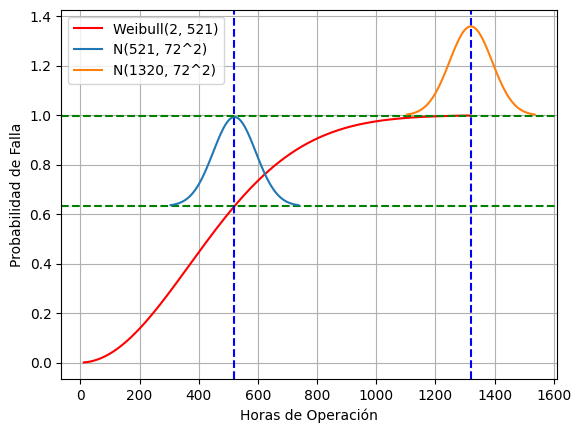

<Figure size 640x480 with 0 Axes>

In [7]:
np.random.seed(5)
# Parámetros de la distribución Weibull
shape = 2  # Parámetro de forma
scale = 530  # Parámetro de escala inicial
target = 1320
tolerance = 1e-3
diff = np.inf
while diff > tolerance:
    samples = scale * np.random.weibull(shape, 1320)
    max_sample = np.max(samples)
    diff = np.abs(max_sample - target)
    scale *= target / max_sample
x = np.sort(samples)
Weibull = 1 - np.exp(-(x / scale) ** shape)
y = 1 - np.exp(-1) # punto del 63.2%
x_value = scale * (-np.log(1 - y))**(1/shape)

median = x_value  
std_dev = 3 * 24 
fails = np.linspace(median -3*std_dev, median + 3*std_dev, 100)
Normal = norm.pdf(fails, median, std_dev) * 65 + y

md = x[-1] 
sd = 3 * 24 
EOL = np.linspace(md -3*sd, md + 3*sd, 100)
dist = norm.pdf(EOL, md, sd) * 65 + Weibull[-1]


plt.plot(x, Weibull, 'r-', label='Weibull(2, 521)')
plt.axhline(y, color='g', linestyle='--')
plt.axvline(x_value, color='b', linestyle='--')
plt.plot(fails, Normal, '-', label='N(521, 72^2)')
plt.axhline(Weibull[-1], color='g', linestyle='--')
plt.axvline(x[-1], color='b', linestyle='--')
plt.plot(EOL, dist, '-', label='N(1320, 72^2)')
plt.xlabel('Horas de Operación')
plt.ylabel('Probabilidad de Falla')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('images/weibull.png')

Luego se usa el valor estimado de `t_EOL` igual a 1320 horas como mediana de una distribución normal con desviación estándar de 72 horas (3 dias). Con esto, se toman 9 valores aleatorios a partir de dicha distribución normal como los valores `t_EOL` respectivos para cada una de las 9 bombas consideradas en la simulación

In [8]:
np.random.seed(5)
EOLs = np.random.choice(EOL, 9)
np.round(EOLs)

array([1536., 1444., 1370., 1174., 1423., 1139., 1375., 1222., 1235.])

Luego se usa el valor estimado de `t_s` igual a 521 horas como mediana de una distribución normal con desviación estándar de 72 horas (3 dias). Con esto, se toman 9 valores aleatorios a partir de dicha distribución normal como los valores `t_s` respectivos para cada una de las 9 bombas consideradas en la simulación.

In [9]:
np.random.seed(5)
t_ss = np.random.choice(fails, 9)
np.round(t_ss)

array([737., 645., 571., 375., 623., 340., 575., 423., 436.])

## Degradación inicial

Los parámetros de degradación son las constantes `B_b`, `A_orifice_cyl` y `A_max_in`. Al considerar sus valores nominales y hacer variaciones en dichos valores según una distribución uniforme _U(0, 0.05)_ para efectos de aleatoriedad (variasión del 5% en los valores de los parámetros) con `np.random.uniform(0, 0.05)`.

1. `B_b` =  0.005729577951308232 [N*m/(rad/s)]
2. `A_orifice` =  1e-09 [m2]
3. `A_max` =  0.0001 [m2]

In [10]:
# Degradación inicial
B_b_crank0 = B_b + B_b * np.random.uniform(0, 0.05)
A_max_in_10 = A_max + A_max * np.random.uniform(0, 0.05)
A_max_in_20 = A_max + A_max * np.random.uniform(0, 0.05)
A_max_in_30 = A_max + A_max * np.random.uniform(0, 0.05)
A_orifice_cyl_10 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_20 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_30 = A_orifice + A_orifice * np.random.uniform(0, 0.05)

In [11]:
[B_b_crank0, A_max_in_10, A_max_in_20, A_max_in_30, A_orifice_cyl_10, A_orifice_cyl_20, A_orifice_cyl_30]

[0.005868989468161656,
 0.00010495410465403354,
 0.00010404140841516634,
 0.0001032472944162205,
 1.0409736396526208e-09,
 1.0121270202690027e-09,
 1.038218630433059e-09]

## Degradación Normal

La degradación normal sigue la siguiente expresión:
$$
\delta_{n}(t) = a_{n}\cdot t + \delta_{0}
$$

para $t \leq t_{s}$ 

Para poder definir el parámetro $a_{n}$, se impone una degradación máxima $m$ del 10 % los parámetros de degradación `B_b`, `A_orifice_cyl` y `A_max_in`, cuando $t = t_{s}$. Por lo tanto, $a_{n}$ se puede definir de la siguiente manera:
$$
a_{n} = \varepsilon \cdot \frac{m \cdot \delta_{0}}{t_{s}}
$$

donde $\varepsilon$ es igual a 1 si la pendiente es positiva y -1 si la pendiente es negativa.

In [12]:
ts = round(t_ss[0])    #ts de la primera bomba
eltiempo = np.arange(0, ts, 1)

m = 0.1 #variación del 10%

#Valores de los parámetros en ts
B_b_normal = B_b_crank0 + (m * B_b_crank0 / ts) * eltiempo
A_max_in_1_normal = A_max_in_10 - (m * A_max_in_10 / ts) * eltiempo
A_max_in_2_normal = A_max_in_20 - (m * A_max_in_20 / ts) * eltiempo
A_max_in_3_normal = A_max_in_30 - (m * A_max_in_30 / ts) * eltiempo
A_orifice_1_normal = A_orifice_cyl_10 + (m * A_orifice_cyl_10 / ts) * eltiempo
A_orifice_2_normal = A_orifice_cyl_20 + (m * A_orifice_cyl_20 / ts) * eltiempo
A_orifice_3_normal = A_orifice_cyl_30 + (m * A_orifice_cyl_30 / ts) * eltiempo

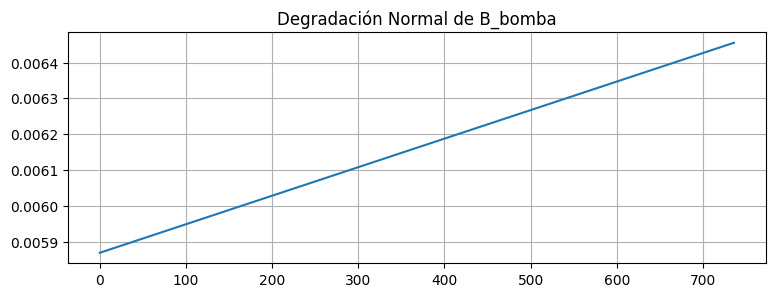

In [13]:
plt.figure(figsize=(9, 3))
plt.plot(eltiempo, B_b_normal, '-')
plt.title('Degradación Normal de B_bomba')
plt.grid(True)

## Degradación Anormal

La degradación anormal sigue la siguiente expresión:
$$
\delta_{a}(t) = 1 - e^{at^{b}} + \delta_{n}(t_{s}) 
$$

para $t = 0$ hasta $t = t_{s}$. 

Al momento de aparecer la degradación anormal (cuando se llega a $t_{s}$), la degradación inicial de la parte anormal es igual a la valor de la degradación normal en $t_{s}$. Al igual que en el caso de la degradación normal, es necesario considerar el tiempo $t_{EOL}$ y un valor de degradación máxima para poder definir los parámetros $a$ y $b$ de la expresión exponencial de la degradación anormal. Si asumimos se asume un valor arbitrario para el parámetro $b$ igual a una ditribución uniforme aleatoria _U(2.0, 3.0)_, es posbile despejar el valor del parámetro $a$ en función de $b$ apartir de la siguiente expresión:
$$
a =\frac{\ln(1+\delta_{n}(t_{s})-\delta_{a}(t_{EOL} - t_{s}))}{(t_{EOL} - t_{s})^{b}}
$$

La degradación máxima se considera cuando el valor del índice de salud global $HI(t)$ sea igual a cero. Esto ocurre cuando uno de los cilindros de la bomba falla completamente debido a un bloqueo total de la válvula de entrada o por una fuga máxima del cilindro en la salida. Bajo estas condiciones el cilindro afectado no aporta al caudal de salida que genera la bomba, y por ende no se alcanza los requerimentos nominales de caudal. Por lo tanto, hay que definir los límites máximos de los parámetros de degradación `B_b`, `A_orifice_cyl` y `A_max_in`.

1. `B_b_max` =  0.06778090716397639 [N*m/(rad/s)]  (`B_b * 11.83` aproximadamente)
2. `A_orifice_max` =  0.0001 [m2]
3. `A_max_min` =  0 [m2] (esta variable decrece)

In [14]:
t_EOL = round(EOLs[0])
eltiempo2 = np.arange(ts, t_EOL, 1)
eltiempo3 = np.arange(0, t_EOL - ts, 1)

b = np.random.uniform(2, 3)
a1 = np.log(1 + B_b_normal[-1] - th_B_b) / ((t_EOL - ts)**b)
a2 = np.log(1 + A_max_in_1_normal[-1] - th_A_max) / ((t_EOL - ts)**b)
a3 = np.log(1 + A_max_in_2_normal[-1] - th_A_max) / ((t_EOL - ts)**b)
a4 = np.log(1 + A_max_in_3_normal[-1] - th_A_max) / ((t_EOL - ts)**b)
a5 = np.log(1 + A_orifice_1_normal[-1] - th_A_orifice) / ((t_EOL - ts)**b)
a6 = np.log(1 + A_orifice_2_normal[-1] - th_A_orifice) / ((t_EOL - ts)**b)
a7 = np.log(1 + A_orifice_3_normal[-1] - th_A_orifice) / ((t_EOL - ts)**b)

#Valores de los parámetros en ts
B_b_anormal = 1 - np.exp(a1 * eltiempo3 **b) + B_b_normal[-1]
A_max_in_1_anormal = 1 - np.exp(a2 * eltiempo3 **b) + A_max_in_1_normal[-1]
A_max_in_2_anormal = 1 - np.exp(a3 * eltiempo3 **b) + A_max_in_2_normal[-1]
A_max_in_3_anormal = 1 - np.exp(a4 * eltiempo3 **b) + A_max_in_3_normal[-1]
A_orifice_1_anormal = 1 - np.exp(a5 * eltiempo3 **b) + A_orifice_1_normal[-1]
A_orifice_2_anormal = 1 - np.exp(a6 * eltiempo3 **b) + A_orifice_2_normal[-1]
A_orifice_3_anormal = 1 - np.exp(a7 * eltiempo3 **b) + A_orifice_3_normal[-1]

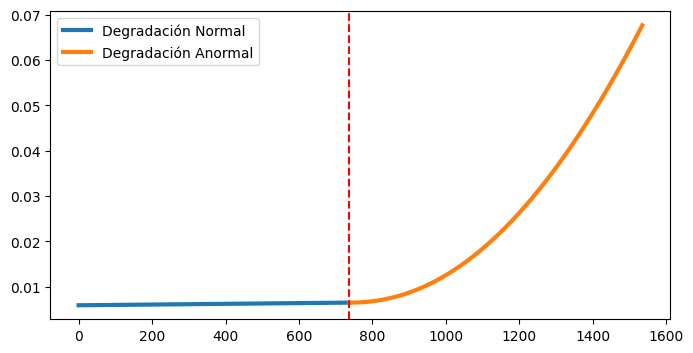

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(eltiempo, B_b_normal, '-', linewidth=3, label='Degradación Normal')
plt.plot(eltiempo2, B_b_anormal, '-', linewidth=3, label='Degradación Anormal')
plt.axvline(ts, color='r', linestyle='--')
plt.legend()
plt.savefig('images/degradation.png', format='png', dpi=300)

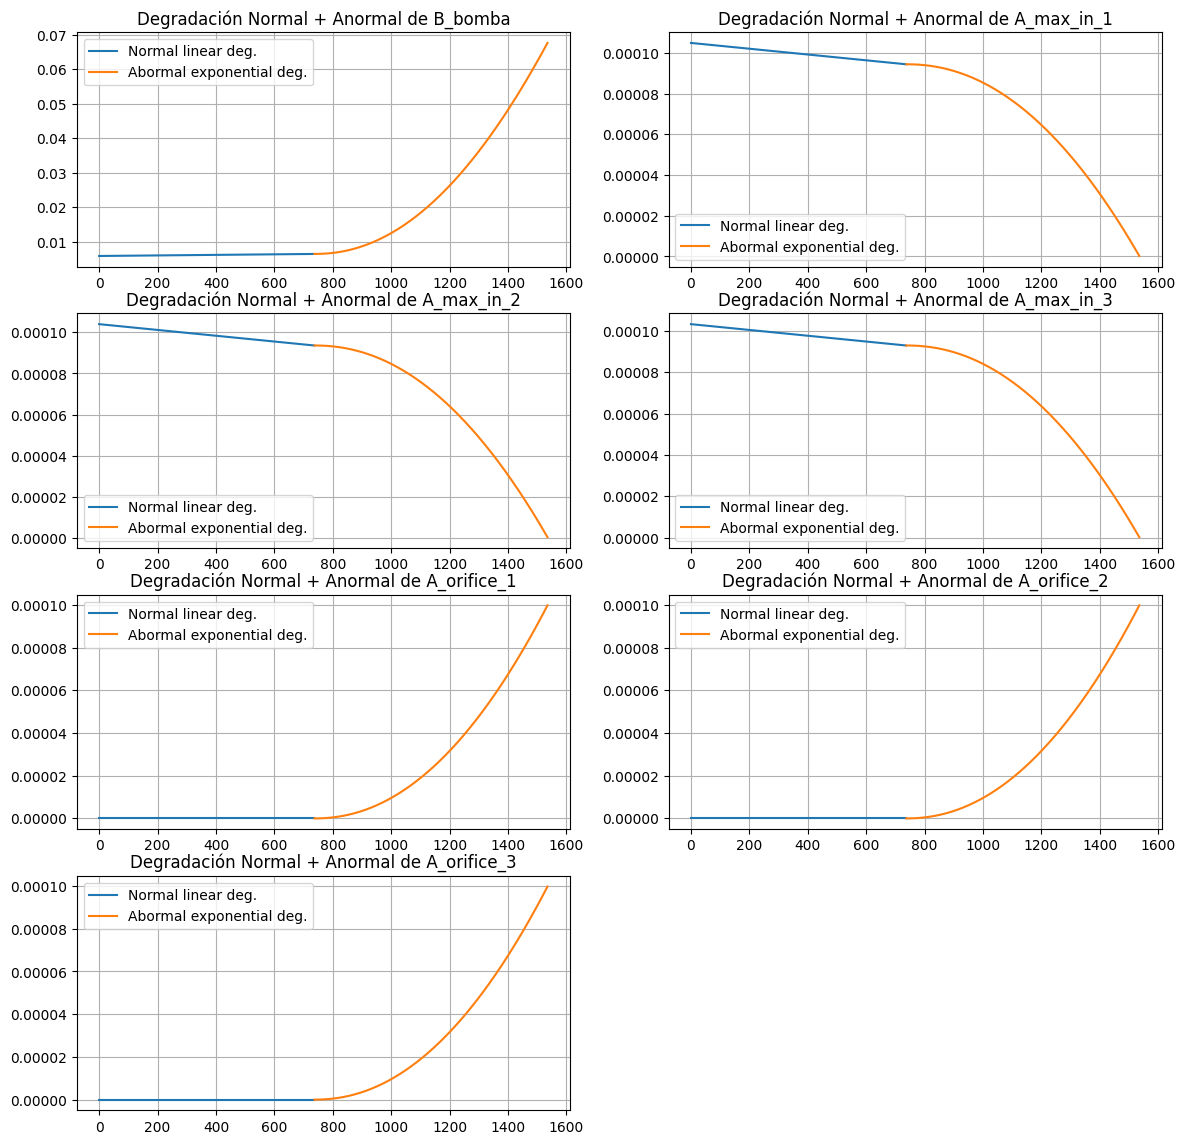

In [16]:
plt.figure(figsize=(14, 14))

plt.subplot(4, 2, 1)
plt.plot(eltiempo, B_b_normal, '-', label='Normal linear deg.')
plt.plot(eltiempo2, B_b_anormal, '-', label='Abormal exponential deg.')
plt.title('Degradación Normal + Anormal de B_bomba')
plt.legend()
plt.grid(True)

plt.subplot(4, 2, 2)
plt.plot(eltiempo, A_max_in_1_normal, '-', label='Normal linear deg.')
plt.plot(eltiempo2, A_max_in_1_anormal, '-', label='Abormal exponential deg.')
plt.title('Degradación Normal + Anormal de A_max_in_1')
plt.legend()
plt.grid(True)

plt.subplot(4, 2, 3)
plt.plot(eltiempo, A_max_in_2_normal, '-', label='Normal linear deg.')
plt.plot(eltiempo2, A_max_in_2_anormal, '-', label='Abormal exponential deg.')
plt.title('Degradación Normal + Anormal de A_max_in_2')
plt.legend()
plt.grid(True)

plt.subplot(4, 2, 4)
plt.plot(eltiempo, A_max_in_3_normal, '-', label='Normal linear deg.')
plt.plot(eltiempo2, A_max_in_3_anormal, '-', label='Abormal exponential deg.')
plt.title('Degradación Normal + Anormal de A_max_in_3')
plt.legend()
plt.grid(True)

plt.subplot(4, 2, 5)
plt.plot(eltiempo, A_orifice_1_normal, '-', label='Normal linear deg.')
plt.plot(eltiempo2, A_orifice_1_anormal, '-', label='Abormal exponential deg.')
plt.title('Degradación Normal + Anormal de A_orifice_1')
plt.legend()
plt.grid(True)

plt.subplot(4, 2, 6)
plt.plot(eltiempo, A_orifice_2_normal, '-', label='Normal linear deg.')
plt.plot(eltiempo2, A_orifice_2_anormal, '-', label='Abormal exponential deg.')
plt.title('Degradación Normal + Anormal de A_orifice_2')
plt.legend()
plt.grid(True)

plt.subplot(4, 2, 7)
plt.plot(eltiempo, A_orifice_3_normal, '-', label='Normal linear deg.')
plt.plot(eltiempo2, A_orifice_3_anormal, '-', label='Abormal exponential deg.')
plt.title('Degradación Normal + Anormal de A_orifice_3')
plt.legend()
plt.grid(True)

plt.show()

## Ejemplo de la simulación

Se ejecutan las funciones para una duración de 0.5 segundos de simulación 

In [17]:
# Variaciones aleatorias del 5% en los parámetros de desgaste nominales
B_b_crank0 = B_b + B_b * np.random.uniform(0, 0.05)
A_max_in_10 = A_max - A_max * np.random.uniform(0, 0.05)
A_max_in_20 = A_max - A_max * np.random.uniform(0, 0.05)
A_max_in_30 = A_max - A_max * np.random.uniform(0, 0.05)
A_orifice_cyl_10 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_20 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_30 = A_orifice + A_orifice * np.random.uniform(0, 0.05)

# Modo de falla, émbolo y válvula afectada
cyl = 'None'
valve = 'None'
fail = 'None'

# Paquete de condiciones iniciales
y0 = [P_cyl_10, P_cyl_20, P_cyl_30, tau_ref0, omega_b0, theta_b0, omega_f0, Tr0, P_in0, P_out0, rho_in0, rho_out0, B_b_crank0, A_max_in_10, A_max_in_20, A_max_in_30, A_orifice_cyl_10, A_orifice_cyl_20, A_orifice_cyl_30]

dt = 0.0001    #diezmilésima
sim_duration = 0.5
t = np.arange(0, sim_duration, dt)
duration = timer()
sol = odeint(sistema, y0, t, atol=1e-4, rtol=1e-4)  
P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3 = sol.T
tau_elec, iMotor, wMotor, Q_in_1, Q_in_2, Q_in_3, Q_out_1, Q_out_2, Q_out_3, Q_in, Q_out = final_values(P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, P_in, P_out, rho_in, rho_out)
duration = timer() - duration
print('duration: ', duration)

duration:  5.616587399999844


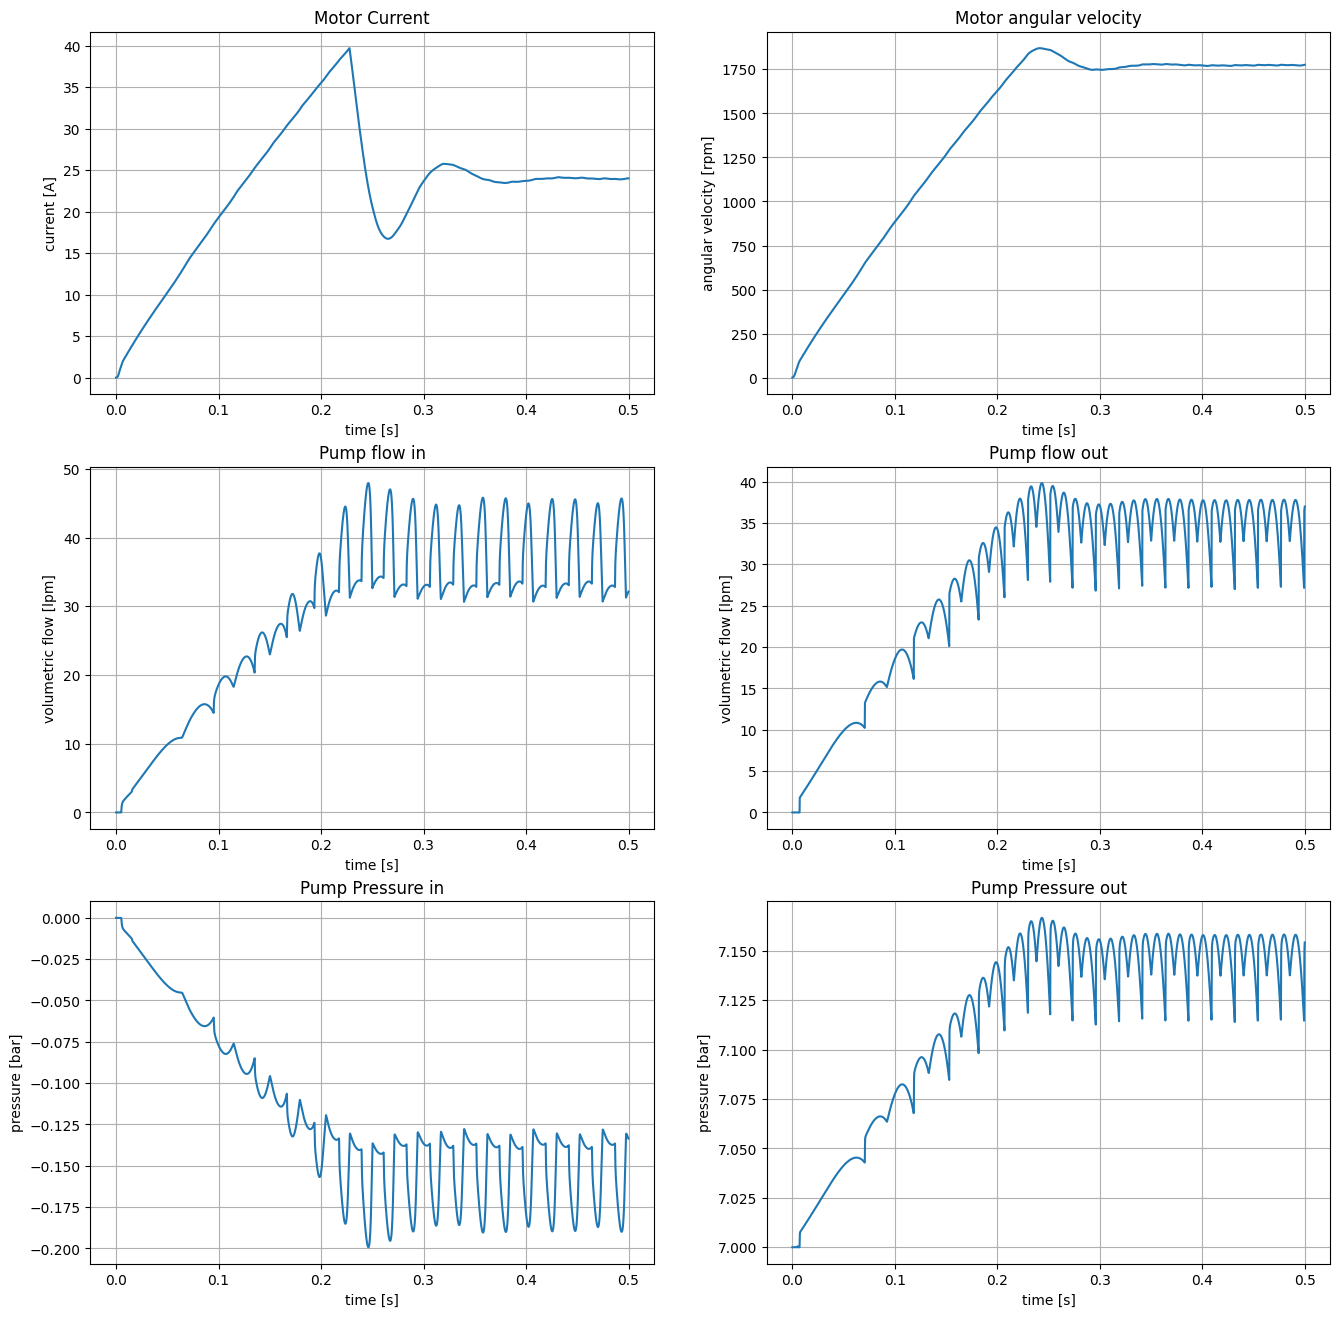

In [18]:
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.plot(t, iMotor, '-')
plt.title('Motor Current')
plt.xlabel('time [s]')
plt.ylabel('current [A]')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(t, wMotor, '-')
plt.title('Motor angular velocity')
plt.xlabel('time [s]')
plt.ylabel('angular velocity [rpm]')
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(t, Q_in * 60000, '-')
plt.title('Pump flow in')
plt.xlabel('time [s]')
plt.ylabel('volumetric flow [lpm]')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(t, Q_out * 60000, '-')
plt.title('Pump flow out')
plt.xlabel('time [s]')
plt.ylabel('volumetric flow [lpm]')
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(t, (P_in - P_atm) / 100000, '-')
plt.title('Pump Pressure in')
plt.xlabel('time [s]')
plt.ylabel('pressure [bar]')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(t, (P_out - P_atm) / 100000, '-')
plt.title('Pump Pressure out')
plt.xlabel('time [s]')
plt.ylabel('pressure [bar]')
plt.grid(True)

Perfil del caudal volumétrico de salida de la bomba cuando no existen fallas (nominal)

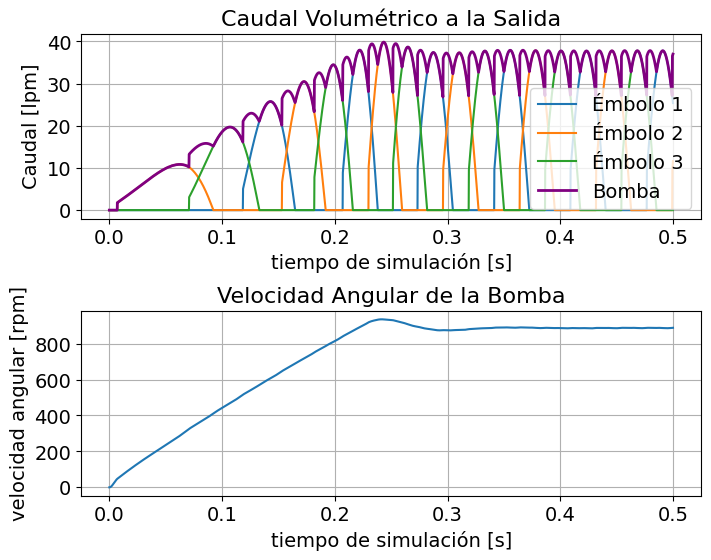

In [19]:
title_size = 16
body_size = 14

plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 2)
plt.plot(t, (wMotor / 2), '-')
plt.title('Velocidad Angular de la Bomba', fontsize=title_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.ylabel('velocidad angular [rpm]', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.grid(True)

plt.subplot(2, 1, 1)
plt.plot(t, Q_out_1 * 60000, '-', label='Émbolo 1')
plt.plot(t, Q_out_2 * 60000, '-', label='Émbolo 2')
plt.plot(t, Q_out_3 * 60000, '-', label='Émbolo 3')
plt.plot(t, Q_out * 60000, '-', color='purple', label='Bomba', linewidth=2)
plt.title('Caudal Volumétrico a la Salida', fontsize=title_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.ylabel('Caudal [lpm]', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.legend(fontsize=body_size)
plt.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.savefig('images/no_faults.png', format='png', dpi=300) 

Efecto de modificación del incremento en la fuga de fluido por degradación de los sellos entre émbolo y cilindro.

In [20]:
# variaciones aleatorias del 5% en los parámetros de desgaste nominales
B_b_crank0 = B_b + B_b * np.random.uniform(0, 0.05)
A_max_in_10 = A_max - A_max * np.random.uniform(0, 0.05)
A_max_in_20 = A_max - A_max * np.random.uniform(0, 0.05)
A_max_in_30 = A_max - A_max * np.random.uniform(0, 0.05)
A_orifice_cyl_10_inicial = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_20 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_30 = A_orifice + A_orifice * np.random.uniform(0, 0.05)

cyl = 'None'
valve = 'None'
fail = 'None'

listas = []
porcentajes = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045]
for i in porcentajes:
    A_orifice_cyl_10 = A_orifice_cyl_10_inicial + A_max * i
    y0 = [P_cyl_10, P_cyl_20, P_cyl_30, tau_ref0, omega_b0, theta_b0, omega_f0, Tr0, P_in0, P_out0, rho_in0, rho_out0, B_b_crank0, A_max_in_10, A_max_in_20, A_max_in_30, A_orifice_cyl_10, A_orifice_cyl_20, A_orifice_cyl_30]
    dt = 0.0001    #diezmilésima
    sim_duration = 0.5
    t = np.arange(0, sim_duration, dt)
    sol = odeint(sistema, y0, t, atol=1e-4, rtol=1e-4)  
    P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3 = sol.T
    tau_elec, iMotor, wMotor, Q_in_1, Q_in_2, Q_in_3, Q_out_1, Q_out_2, Q_out_3, Q_in, Q_out = final_values(P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, P_in, P_out, rho_in, rho_out)
    listas.append([iMotor, Q_out])

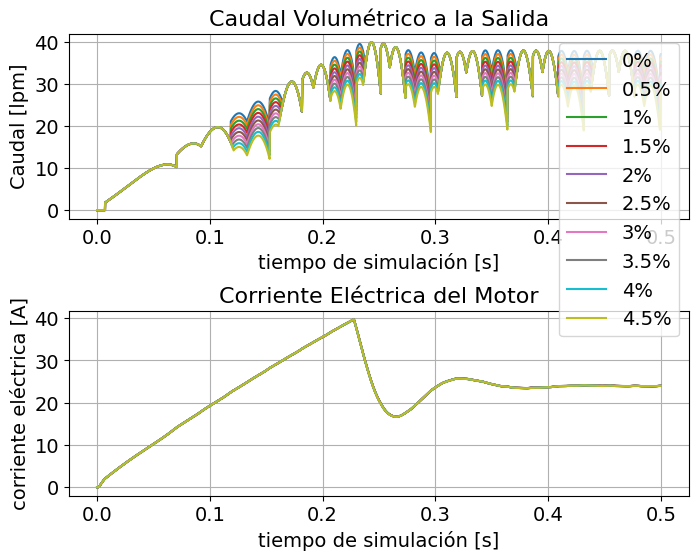

In [21]:
title_size = 16
body_size = 14
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 2)
plt.plot(t, listas[0][0], '-', color=colors[0])
plt.plot(t, listas[1][0], '-', color=colors[1])
plt.plot(t, listas[2][0], '-', color=colors[2])
plt.plot(t, listas[3][0], '-', color=colors[3])
plt.plot(t, listas[4][0], '-', color=colors[4])
plt.plot(t, listas[5][0], '-', color=colors[5])
plt.plot(t, listas[6][0], '-', color=colors[6])
plt.plot(t, listas[7][0], '-', color=colors[7])
plt.plot(t, listas[8][0], '-', color=colors[9])
plt.plot(t, listas[9][0], '-', color=colors[8])
plt.title('Corriente Eléctrica del Motor', fontsize=title_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.ylabel('corriente eléctrica [A]', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.grid(True)

plt.subplot(2, 1, 1)
plt.plot(t, listas[0][1] * 60000, '-', color=colors[0], label='0%')
plt.plot(t, listas[1][1] * 60000, '-', color=colors[1], label='0.5%')
plt.plot(t, listas[2][1] * 60000, '-', color=colors[2], label='1%')
plt.plot(t, listas[3][1] * 60000, '-', color=colors[3], label='1.5%')
plt.plot(t, listas[4][1] * 60000, '-', color=colors[4], label='2%')
plt.plot(t, listas[5][1] * 60000, '-', color=colors[5], label='2.5%')
plt.plot(t, listas[6][1] * 60000, '-', color=colors[6], label='3%')
plt.plot(t, listas[7][1] * 60000, '-', color=colors[7], label='3.5%')
plt.plot(t, listas[8][1] * 60000, '-', color=colors[9], label='4%')
plt.plot(t, listas[9][1] * 60000, '-', color=colors[8], label='4.5%')
plt.title('Caudal Volumétrico a la Salida', fontsize=title_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.ylabel('Caudal [lpm]', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.legend(loc='upper right', fontsize=body_size)
plt.grid(True)

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.savefig('images/Increasing_LeakSeal_embolo1.png', format='png', dpi=300)  

Efecto de modificación del incremento en el bloqueo u obstrucción de la válvula de retención de entrada.

In [22]:
# variaciones aleatorias del 5% en los parámetros de desgaste nominales
B_b_crank0 = B_b + B_b * np.random.uniform(0, 0.05)
A_max_in_10_inicial = A_max - A_max * np.random.uniform(0, 0.05)
A_max_in_20 = A_max - A_max * np.random.uniform(0, 0.05)
A_max_in_30 = A_max - A_max * np.random.uniform(0, 0.05)
A_orifice_cyl_10 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_20 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_30 = A_orifice + A_orifice * np.random.uniform(0, 0.05)

cyl = 'None'
valve = 'None'
fail = 'None'

listas = []
porcentajes = [0.2, 0.23, 0.26, 0.29, 0.32, 0.35, 0.38, 0.41, 0.44, 0.47]
for i in porcentajes:
    A_max_in_10 = A_max_in_10_inicial - A_max * i
    y0 = [P_cyl_10, P_cyl_20, P_cyl_30, tau_ref0, omega_b0, theta_b0, omega_f0, Tr0, P_in0, P_out0, rho_in0, rho_out0, B_b_crank0, A_max_in_10, A_max_in_20, A_max_in_30, A_orifice_cyl_10, A_orifice_cyl_20, A_orifice_cyl_30]
    dt = 0.0001    #diezmilésima
    sim_duration = 0.5
    t = np.arange(0, sim_duration, dt)
    sol = odeint(sistema, y0, t, atol=1e-4, rtol=1e-4)  
    P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3 = sol.T
    tau_elec, iMotor, wMotor, Q_in_1, Q_in_2, Q_in_3, Q_out_1, Q_out_2, Q_out_3, Q_in, Q_out = final_values(P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, P_in, P_out, rho_in, rho_out)
    listas.append([iMotor, Q_out])

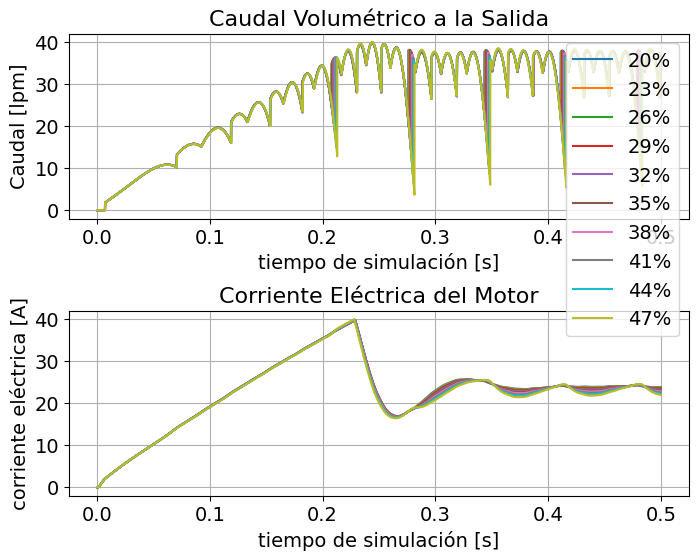

In [23]:
title_size = 16
body_size = 14
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 2)
plt.plot(t, listas[0][0], '-', color=colors[0])
plt.plot(t, listas[1][0], '-', color=colors[1])
plt.plot(t, listas[2][0], '-', color=colors[2])
plt.plot(t, listas[3][0], '-', color=colors[3])
plt.plot(t, listas[4][0], '-', color=colors[4])
plt.plot(t, listas[5][0], '-', color=colors[5])
plt.plot(t, listas[6][0], '-', color=colors[6])
plt.plot(t, listas[7][0], '-', color=colors[7])
plt.plot(t, listas[8][0], '-', color=colors[9])
plt.plot(t, listas[9][0], '-', color=colors[8])
plt.title('Corriente Eléctrica del Motor', fontsize=title_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.ylabel('corriente eléctrica [A]', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.grid(True)

plt.subplot(2, 1, 1)
plt.plot(t, listas[0][1] * 60000, '-', color=colors[0], label='20%')
plt.plot(t, listas[1][1] * 60000, '-', color=colors[1], label='23%')
plt.plot(t, listas[2][1] * 60000, '-', color=colors[2], label='26%')
plt.plot(t, listas[3][1] * 60000, '-', color=colors[3], label='29%')
plt.plot(t, listas[4][1] * 60000, '-', color=colors[4], label='32%')
plt.plot(t, listas[5][1] * 60000, '-', color=colors[5], label='35%')
plt.plot(t, listas[6][1] * 60000, '-', color=colors[6], label='38%')
plt.plot(t, listas[7][1] * 60000, '-', color=colors[7], label='41%')
plt.plot(t, listas[8][1] * 60000, '-', color=colors[9], label='44%')
plt.plot(t, listas[9][1] * 60000, '-', color=colors[8], label='47%')
plt.title('Caudal Volumétrico a la Salida', fontsize=title_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.ylabel('Caudal [lpm]', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.legend(loc='upper right', fontsize=body_size)
plt.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.savefig('images/Increasing_BlockedIn_embolo1.png', format='png', dpi=300)  

Efecto de modificación del incremento en la degradación de los cojinetes del eje cigüeñal de la bomba.

In [24]:
# variaciones aleatorias del 5% en los parámetros de desgaste nominales
B_b_crank0_inicial = B_b + B_b * np.random.uniform(0, 0.05)
A_max_in_10 = A_max - A_max * np.random.uniform(0, 0.05)
A_max_in_20 = A_max - A_max * np.random.uniform(0, 0.05)
A_max_in_30 = A_max - A_max * np.random.uniform(0, 0.05)
A_orifice_cyl_10 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_20 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
A_orifice_cyl_30 = A_orifice + A_orifice * np.random.uniform(0, 0.05)

cyl = 'None'
valve = 'None'
fail = 'None'

listas = []
added = (np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) / (2 * np.pi / 360)) / 1000 
for i in added:
    B_b_crank0 = B_b_crank0_inicial + i 
    y0 = [P_cyl_10, P_cyl_20, P_cyl_30, tau_ref0, omega_b0, theta_b0, omega_f0, Tr0, P_in0, P_out0, rho_in0, rho_out0, B_b_crank0, A_max_in_10, A_max_in_20, A_max_in_30, A_orifice_cyl_10, A_orifice_cyl_20, A_orifice_cyl_30]
    dt = 0.0001    #diezmilésima
    sim_duration = 0.5
    t = np.arange(0, sim_duration, dt)
    sol = odeint(sistema, y0, t, atol=1e-4, rtol=1e-4)  
    P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3 = sol.T
    tau_elec, iMotor, wMotor, Q_in_1, Q_in_2, Q_in_3, Q_out_1, Q_out_2, Q_out_3, Q_in, Q_out = final_values(P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, P_in, P_out, rho_in, rho_out)
    listas.append([iMotor, Q_out])

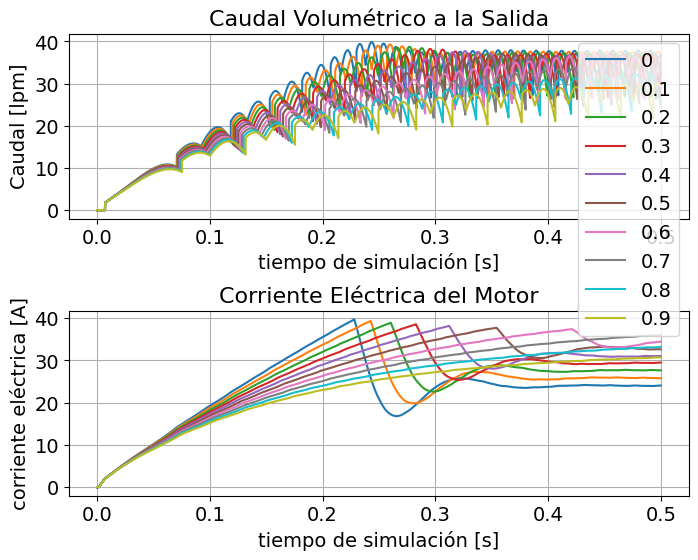

In [25]:
title_size = 16
body_size = 14
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 2)
plt.plot(t, listas[0][0], '-', color=colors[0])
plt.plot(t, listas[1][0], '-', color=colors[1])
plt.plot(t, listas[2][0], '-', color=colors[2])
plt.plot(t, listas[3][0], '-', color=colors[3])
plt.plot(t, listas[4][0], '-', color=colors[4])
plt.plot(t, listas[5][0], '-', color=colors[5])
plt.plot(t, listas[6][0], '-', color=colors[6])
plt.plot(t, listas[7][0], '-', color=colors[7])
plt.plot(t, listas[8][0], '-', color=colors[9])
plt.plot(t, listas[9][0], '-', color=colors[8])
plt.title('Corriente Eléctrica del Motor', fontsize=title_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.ylabel('corriente eléctrica [A]', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.grid(True)

plt.subplot(2, 1, 1)
plt.plot(t, listas[0][1] * 60000, '-', color=colors[0], label='0')
plt.plot(t, listas[1][1] * 60000, '-', color=colors[1], label='0.1')
plt.plot(t, listas[2][1] * 60000, '-', color=colors[2], label='0.2')
plt.plot(t, listas[3][1] * 60000, '-', color=colors[3], label='0.3')
plt.plot(t, listas[4][1] * 60000, '-', color=colors[4], label='0.4')
plt.plot(t, listas[5][1] * 60000, '-', color=colors[5], label='0.5')
plt.plot(t, listas[6][1] * 60000, '-', color=colors[6], label='0.6')
plt.plot(t, listas[7][1] * 60000, '-', color=colors[7], label='0.7')
plt.plot(t, listas[8][1] * 60000, '-', color=colors[9], label='0.8')
plt.plot(t, listas[9][1] * 60000, '-', color=colors[8], label='0.9')
plt.title('Caudal Volumétrico a la Salida', fontsize=title_size)
plt.xlabel('tiempo de simulación [s]', fontsize=body_size)
plt.ylabel('Caudal [lpm]', fontsize=body_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.legend(loc='upper right', fontsize=body_size)
plt.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.savefig('images/Increasing_WornBearing.png', format='png', dpi=300)  

#### Selección $t_{s}$ y $t_{EOL}$ para las trayectorias de degradación de las bombas

In [26]:
np.random.seed(2)
EOLs = np.random.choice(EOL, 14)
EOLs

array([1278.54613763, 1169.45522853, 1418.18250126, 1200.00068308,
       1291.63704672, 1461.8188649 , 1431.27341035, 1134.54613763,
       1252.36431944, 1317.8188649 , 1518.54613763, 1431.27341035,
       1474.90977399, 1309.09159217])

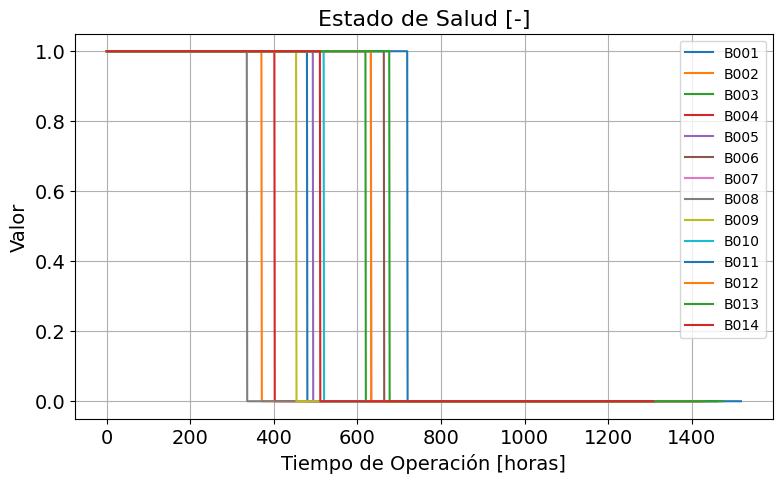

In [27]:
#np.random.seed(2)
#t_ss = np.random.choice(fails, 14)
#t_ss

EOLs = [1279, 1169, 1418, 1200, 1292, 1462, 1431, 1135, 1252, 1318, 1519, 1431, 1475, 1309]
t_ss = [479, 370, 619, 401, 493, 663, 632, 335, 453, 519, 719, 632, 676, 510]

pump_1 = np.array([1 if i <= np.round(t_ss[0]) else 0 for i in range(int(np.round(EOLs[0])))])
pump_2 = np.array([1 if i <= np.round(t_ss[1]) else 0 for i in range(int(np.round(EOLs[1])))])
pump_3 = np.array([1 if i <= np.round(t_ss[2]) else 0 for i in range(int(np.round(EOLs[2])))])
pump_4 = np.array([1 if i <= np.round(t_ss[3]) else 0 for i in range(int(np.round(EOLs[3])))])
pump_5 = np.array([1 if i <= np.round(t_ss[4]) else 0 for i in range(int(np.round(EOLs[4])))])
pump_6 = np.array([1 if i <= np.round(t_ss[5]) else 0 for i in range(int(np.round(EOLs[5])))])
pump_7 = np.array([1 if i <= np.round(t_ss[6]) else 0 for i in range(int(np.round(EOLs[6])))])
pump_8 = np.array([1 if i <= np.round(t_ss[7]) else 0 for i in range(int(np.round(EOLs[7])))])
pump_9 = np.array([1 if i <= np.round(t_ss[8]) else 0 for i in range(int(np.round(EOLs[8])))])
pump_10 = np.array([1 if i <= np.round(t_ss[9]) else 0 for i in range(int(np.round(EOLs[9])))])
pump_11 = np.array([1 if i <= np.round(t_ss[10]) else 0 for i in range(int(np.round(EOLs[10])))])
pump_12 = np.array([1 if i <= np.round(t_ss[11]) else 0 for i in range(int(np.round(EOLs[11])))])
pump_13 = np.array([1 if i <= np.round(t_ss[12]) else 0 for i in range(int(np.round(EOLs[12])))])
pump_14 = np.array([1 if i <= np.round(t_ss[13]) else 0 for i in range(int(np.round(EOLs[13])))])

pumps = [pump_1, pump_2, pump_3, pump_4, pump_5, pump_6, pump_7, pump_8, pump_9, pump_10, pump_11, pump_12, pump_13, pump_14]
labels = ['B001', 'B002', 'B003', 'B004', 'B005', 'B006', 'B007', 'B008', 'B009', 'B010', 'B011', 'B012', 'B013', 'B014']

plt.figure(figsize=(9, 5))
title_size = 16
body_size = 14
for i in range(len(pumps)):
    plt.plot(np.arange(0, len(pumps[i]), 1), pumps[i], label = labels[i])
plt.xlabel('Tiempo de Operación [horas]', fontsize=body_size)
plt.ylabel('Valor', fontsize=body_size)
plt.title('Estado de Salud [-]', fontsize=title_size)
plt.xticks(fontsize=body_size)
plt.yticks(fontsize=body_size)
plt.legend(fontsize=body_size-4)
plt.grid(True)
plt.savefig('images/hs_graph.png', format='png', dpi=300)  

In [28]:
np.round(EOLs)

array([1279, 1169, 1418, 1200, 1292, 1462, 1431, 1135, 1252, 1318, 1519,
       1431, 1475, 1309])

In [29]:
np.round(t_ss)

array([479, 370, 619, 401, 493, 663, 632, 335, 453, 519, 719, 632, 676,
       510])

## Simulación de la operación hasta el fallo de las bombas (trayectoria de degradació al fallo)

Primero ejecutamos la simulación sin fallas hasta un momento donde se alcanza el estado estacionario.

In [ ]:
units = [
    'B001', 'B002', 'B003', 'B004', 'B005', 'B006', 'B007', 
    'B008', 'B009', 'B010', 'B011', 'B012', 'B013', 'B014', 
]
for unit in units:
    
    # variaciones aleatorias del 5% en los parámetros de desgaste nominales
    B_b_crank0 = B_b + B_b * np.random.uniform(0, 0.05)
    A_max_in_10 = A_max - A_max * np.random.uniform(0, 0.05)
    A_max_in_20 = A_max - A_max * np.random.uniform(0, 0.05)
    A_max_in_30 = A_max - A_max * np.random.uniform(0, 0.05)
    A_orifice_cyl_10 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
    A_orifice_cyl_20 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
    A_orifice_cyl_30 = A_orifice + A_orifice * np.random.uniform(0, 0.05)
    
    # Modo de falla, émbolo y válvula afectada
    cyl = 'None'
    valve = 'None'
    fail = 'No'
    
    # Paquete de condiciones iniciales
    y0 = [P_cyl_10, P_cyl_20, P_cyl_30, tau_ref0, omega_b0, theta_b0, omega_f0, Tr0, P_in0, P_out0, rho_in0, rho_out0, B_b_crank0, A_max_in_10, A_max_in_20, A_max_in_30, A_orifice_cyl_10, A_orifice_cyl_20, A_orifice_cyl_30]
    dt = 0.0001    #diezmilésima
    sim_duration = 120
    t = np.arange(0, sim_duration, dt)
    duration = timer()
    sol = odeint(sistema, y0, t, atol=1e-4, rtol=1e-4)  
    P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3 = sol.T
    duration = timer() - duration
    print('duration: ', duration)
    
    # las condiciones iniciales se actualizan a valores de operación nominal estacionaria
    y0 = [
        P_cyl_1[-1], P_cyl_2[-1], P_cyl_3[-1], 
        tau_ref[-1], omega_b[-1], theta_b[-1], 
        omega_f[-1], Tr[-1], P_in[-1], P_out[-1], 
        rho_in[-1], rho_out[-1], B_b_crank[-1], 
        A_max_in_1[-1], A_max_in_2[-1], A_max_in_3[-1], 
        A_orifice_cyl_1[-1], A_orifice_cyl_2[-1], A_orifice_cyl_3[-1]
    ]
    # Los paquetes con las "nuevas" condiciones iniciales se guardan para cada bomba
    with open(f'B0xx_y0/{unit}_y0.pkl', 'wb') as f:
        pickle.dump(y0, f)

Luego, se ejecuta la simulación completa con la duración correspondiente a partir de estas nuevas condiciones iniciales:

En este caso además se seleccionan los siguientes modos de falla para cada bomba:

<img src='images/failure_modes_table.png' >

Con el siguiente código se ejecutará la simulación de las 14 bombas de manera secuencial. Como la resolución temporal es del orden de la diezmilésima y la operación acelerada de las bombas es del orden de las miles de horas, se generarán del ordén del millon de 'muestras', por lo que se generarán archivos de alrededor de 2 GB en cada caso. Se recomienda ejecutar la simulación de las 14 bombas seguidas si se dispone de al menos 32 GB de ram, de otro modo se debe ejecutar la simulación de la mitad de las bombas (eliminar hasta la bomba ``B007`` de la lista ``units``) para luego seguir con el resto, luego de haber reiniciado el kernel del notebook para liberar memoria.

In [ ]:
units = [
    'B001', 'B002', 'B003', 'B004', 'B005', 'B006', 'B007', 
    'B008', 'B009', 'B010', 'B011', 'B012', 'B013', 'B014', 
]
failure_modes = [
    'WornBearing', 'LeakSeal', 'BlockedIn', 'WornBearing_BlockedIn', 
    'WornBearing_LeakSeal', 'BlockedIn_LeakSeal', 'WornBearing_BlockedIn', 
    'WornBearing_LeakSeal', 'WornBearing_LeakSeal_BlockedIn', 'WornBearing', 
    'LeakSeal', 'BlockedIn', 'BlockedIn_LeakSeal','WornBearing_LeakSeal_BlockedIn'
] 
cylinder = ['None', '1', 'None', 'None', '2', '3', 'None', '1', '2', 'None', '3', 'None', '1', '3']
check_valve = ['None', 'None', '2', '1', 'None', '2', '3', 'None', '1', 'None', 'None', '1', '1', '3']

for unit in range(len(units)):
    # variación aleatoria del parámetro b
    b = np.random.uniform(2.0, 3.0)
    
    # se inicia la prueba de degradación acelerada desde las condiciones iniciales en estado estacionario
    with open(path_y0 + f'{units[unit]}_y0.pkl', 'rb') as f:
        y0 = pickle.load(f)
    
    cyl = cylinder[unit]
    valve = check_valve[unit]
    fail = failure_modes[unit]
    
    ts = np.round(t_ss[unit])
    t_EOL = np.round(EOLs[unit])
    
    dt = 0.0001    #diezmilésima
    sim_duration = t_EOL
    t = np.arange(0, sim_duration, dt)
    duration = timer()
    sol = odeint(sistema, y0, t, atol=1e-4, rtol=1e-4)  
    P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3 = sol.T
    duration = timer() - duration
    print('duration: ', duration)
    
    with open(f'B0xx_raw/{units[unit]}_raw.pkl', 'wb') as f:
        pickle.dump([P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3], f)

Para guardar todos los conjuntos de simulación generados en Dataframes de Pandas, primero se cargan los datos crudos del ejercicio de simulación anterior (``raw`` data), y luego se generan una lista con las últimas variables de estado que faltan. Al igual que en el ejercicio de simulación, en esta parte final se recomienda contar con al menos 32 GB de ram si se quieren generar los Dataframes finales de las 14 bombas de manera automática y secuencial.

In [ ]:
units = [
    'B001', 'B002', 'B003', 'B004', 'B005', 'B006', 'B007', 
    'B008', 'B009', 'B010', 'B011', 'B012', 'B013', 'B014', 
]
for unit in units:
    with open(f'B0xx_raw/{unit}_raw.pkl', 'rb') as f:
        P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3 = pickle.load(f)
    tau_elec, iMotor, wMotor, Q_in_1, Q_in_2, Q_in_3, Q_out_1, Q_out_2, Q_out_3, Q_in, Q_out = final_values(P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, P_in, P_out, rho_in, rho_out)
    data = [
        P_cyl_1, P_cyl_2, P_cyl_3, tau_ref, omega_b, theta_b, omega_f, Tr, P_in, P_out, rho_in, rho_out, 
        B_b_crank, A_max_in_1, A_max_in_2, A_max_in_3, A_orifice_cyl_1, A_orifice_cyl_2, A_orifice_cyl_3, 
        tau_elec, iMotor, wMotor, Q_in_1, Q_in_2, Q_in_3, Q_out_1, Q_out_2, Q_out_3, Q_in, Q_out
    ]  
    df = pd.DataFrame(data).T
    df.columns = [
        'P_cyl_1', 'P_cyl_2', 'P_cyl_3','tau_ref', 'omega_b', 'theta_b', 'omega_f', 'Tr', 'P_in', 'P_out', 'rho_in', 'rho_out', 
        'B_b_crank', 'A_max_in_1', 'A_max_in_2', 'A_max_in_3', 'A_orifice_cyl_1', 'A_orifice_cyl_2', 'A_orifice_cyl_3', 
        'tau_elec', 'iMotor', 'wMotor', 'Q_in_1', 'Q_in_2', 'Q_in_3', 'Q_out_1', 'Q_out_2', 'Q_out_3', 'Q_in', 'Q_out'
    ]
    df.to_pickle(f'B0xx_simulation/{unit}_simulation.pkl')